In [21]:
import json
import pandas as pd
import numpy as np
import math
import re

from sqlalchemy import create_engine
import psycopg2

# from config import db_password

import time

In [2]:
# 1. Add the clean movie function that takes in the argument, "movie".
def clean_movie(movie):
    movie = dict(movie)
    alt_titles = {}
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune–Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
        if len(alt_titles) > 0:
            movie['alt_titles'] = alt_titles
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')
    return movie

In [3]:
def parse_dollars(s):
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan

    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a million
        value = float(s) * 10**6

        # return value
        return value

    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a billion
        value = float(s) * 10**9

        # return value
        return value

    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

        # remove dollar sign and commas
        s = re.sub('\$|,','', s)

        # convert to float
        value = float(s)

        # return value
        return value

    # otherwise, return NaN
    else:
        return np.nan

In [4]:
# 2 Add the function that takes in three arguments;
# Wikipedia data, Kaggle metadata, and MovieLens rating data (from Kaggle)

def extract_transform_load(kaggle,rating,wiki):
    # Read in the kaggle metadata and MovieLens ratings CSV files as Pandas DataFrames.
    kaggle_metadata = pd.read_csv(kaggle, low_memory=False)
    ratings = pd.read_csv(rating)

    # Open and read the Wikipedia data JSON file.
    with open(wiki, mode = 'r') as file:
        wiki_movies_raw = json.load(file)
    wiki_movies_df = pd.DataFrame(wiki_movies_raw)
    wiki_movies_df.columns.tolist()
    
    # 3. Write a list comprehension to filter out TV shows.
    wiki_movies = [movie for movie in wiki_movies_raw 
        if('Director' in movie or 'Directed by' in movie) 
        and 'imdb_link' in movie
        and 'No. of episodes' not in  movie]

    # 4. Write a list comprehension to iterate through the cleaned wiki movies list
    # and call the clean_movie function on each movie.
    clean_movies = [clean_movie(movie) for movie in wiki_movies]

    # 5. Read in the cleaned movies list from Step 4 as a DataFrame.
    wiki_movies_df = pd.DataFrame(clean_movies)
    sorted(wiki_movies_df.columns.tolist())

    # 6. Write a try-except block to catch errors while extracting the IMDb ID using a regular expression string and
    #  dropping any imdb_id duplicates. If there is an error, capture and print the exception.
    try:
        wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
        
    except Exception as e: print(e)
    
    wiki_movies_df.drop_duplicates(subset = 'imdb_id', inplace = True)
    wiki_movies_df['imdb_id'].tail()

    #  7. Write a list comprehension to keep the columns that don't have null values from the wiki_movies_df DataFrame.
    wiki_columns_to_keep = [column for column in wiki_movies_df.columns if (wiki_movies_df[column].isnull().sum()/len(wiki_movies_df)) <= .9]
    wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]
    wiki_movies_df.head()

    # 8. Create a variable that will hold the non-null values from the “Box office” column.
    box_office = wiki_movies_df["Box office"].dropna()
    
    # 9. Convert the box office data created in Step 8 to string values using the lambda and join functions.
    box_office[box_office.map(lambda x: type(x) != str)]
    box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)

    # 10. Write a regular expression to match the six elements of "form_one" of the box office data.
    form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
    matches_form_one = box_office.str.contains(form_one, flags = re.IGNORECASE, na = False)
   
    # 11. Write a regular expression to match the three elements of "form_two" of the box office data.
    form_two = r'\$\s*\d{1,3}(?:,\d{3})+'
    matches_form_two = box_office.str.contains(form_two, flags = re.IGNORECASE, na = False)
    box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

    # 12. Add the parse_dollars function.
    # see function above
    
    # 13. Clean the box office column in the wiki_movies_df DataFrame.
    wiki_movies_df['Box office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
    
    # 14. Clean the budget column in the wiki_movies_df DataFrame.
    budget = wiki_movies_df["Budget"].dropna()
    budget = budget.apply(lambda x: ' '.join(x) if type(x) == list else x)
    budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)
    form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
    matches_form_one = budget.str.contains(form_one, flags = re.IGNORECASE, na = False)
    form_two = r'\$\s*\d{1,3}(?:,\d{3})+'
    matches_form_two = budget.str.contains(form_two, flags = re.IGNORECASE, na = False)
    budget[~matches_form_one & ~matches_form_two]
    wiki_movies_df['Budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

    # 15. Clean the release date column in the wiki_movies_df DataFrame.
    release_date = wiki_movies_df["Release date"].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
    date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}'
    date_form_two = r'\d{4}.[01]\d.[0123]\d'
    date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
    date_form_four = r'\d{4}'
    wiki_movies_df["Release date"] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format = True)

    # 16. Clean the running time column in the wiki_movies_df DataFrame.
    running_time = wiki_movies_df["Running time"].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
    running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')
    running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors = 'coerce')).fillna(0)
    wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)
    
    # Return three variables. The first is the wiki_movies_df DataFrame
    
    return wiki_movies_df, kaggle_metadata, ratings 

In [5]:
# 17. Create the path to your file directory and variables for the three files.
file_dir = '/Users/jaredschwartz/Downloads'
# The Wikipedia data
wiki_file = f'{file_dir}/wikipedia-movies.json'
# The Kaggle metadata
kaggle_file = f'{file_dir}/movies_metadata.csv'
# The MovieLens rating data.
ratings_file = f'{file_dir}/ratings.csv'

In [6]:
# 18. Set the three variables equal to the function created in D1.
wiki_file, kaggle_file, ratings_file = extract_transform_load(kaggle_file, ratings_file, wiki_file)

In [7]:
# 19. Set the wiki_movies_df equal to the wiki_file variable. 
wiki_movies_df = wiki_file

In [8]:
# 20. Check that the wiki_movies_df DataFrame looks like this. 
wiki_movies_df.head()

,url,year,imdb_link,title,Based on,Starring,Cinematography,Release date,Running time,Country,...,Box office,Director,Distributor,Editor(s),Composer(s),Producer(s),Production company(s),Writer(s),imdb_id,running_time
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,1990-07-11,102 minutes,United States,...,21400000.0,Renny Harlin,20th Century Fox,Michael Tronick,"[Cliff Eidelman, Yello]","[Steve Perry, Joel Silver]",Silver Pictures,"[David Arnott, James Cappe]",tt0098987,102.0
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,1990-05-17,114 minutes,United States,...,2700000.0,James Foley,Avenue Pictures,Howard E. Smith,Maurice Jarre,"[Ric Kidney, Robert Redlin]",Avenue Pictures,"[James Foley, Robert Redlin]",tt0098994,114.0
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,1990-08-10,113 minutes,United States,...,57718089.0,Roger Spottiswoode,TriStar Pictures,"[John Bloom, Lois Freeman-Fox]",Charles Gross,Daniel Melnick,"[Carolco Pictures, IndieProd Company]","[John Eskow, Richard Rush]",tt0099005,113.0
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,1990-12-25,106 minutes,United States,...,7331647.0,Woody Allen,Orion Pictures,Susan E. Morse,NaN,Robert Greenhut,NaN,Woody Allen,tt0099012,106.0
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,1990-12-19,95 minutes,US,...,6939946.0,John Cornell,Paramount Pictures,David Stiven,Maurice Jarre,John Cornell,NaN,Paul Hogan,tt0099018,95.0


In [9]:
# 21. Check that wiki_movies_df DataFrame columns are correct. 
wiki_movies_df.columns.to_list()

['url',
 'year',
 'imdb_link',
 'title',
 'Based on',
 'Starring',
 'Cinematography',
 'Release date',
 'Running time',
 'Country',
 'Language',
 'Budget',
 'Box office',
 'Director',
 'Distributor',
 'Editor(s)',
 'Composer(s)',
 'Producer(s)',
 'Production company(s)',
 'Writer(s)',
 'imdb_id',
 'running_time']

In [10]:
kaggle_metadata = kaggle_file
kaggle_metadata['adult'].value_counts()
kaggle_metadata['video'].value_counts()

False    45367
True        93
Name: video, dtype: int64

In [11]:
kaggle_metadata[~kaggle_metadata['adult'].isin(['True','False'])]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')
kaggle_metadata['video'].apply(lambda x: bool(x))

0        False
1        False
2        False
3        False
4        False
         ...  
45461    False
45462    False
45463    False
45464    False
45465    False
Name: video, Length: 45454, dtype: bool

In [13]:
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')
kaggle_metadata["release_date"] = pd.to_datetime(kaggle_metadata["release_date"])

In [14]:
ratings = ratings_file
ratings.info(null_counts = True)

/var/folders/g4/q3cwhdfx0wn6r_5q7yht59lh0000gn/T/ipykernel_5041/4193268517.py:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  ratings.info(null_counts = True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

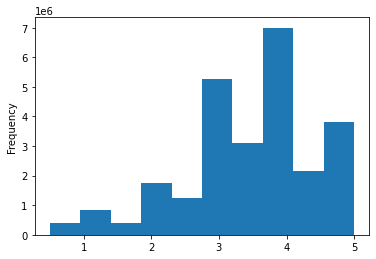

In [15]:
ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], unit = 's')
pd.options.display.float_format = '{:20,.2f}'.format
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()

In [16]:
movies_df = pd.merge(wiki_movies_df, kaggle_metadata, on='imdb_id', suffixes=['_wiki','_kaggle'])
movies_df[movies_df['title_wiki'] != movies_df['title_kaggle']][['title_wiki','title_kaggle']]

,title_wiki,title_kaggle
27,China Cry,China Cry: A True Story
36,Daddy's Dyin' ...Who's Got the Will?,Daddy's Dyin'... Who's Got the Will?
38,The Dark Side of the Moon,The Dark Side of The Moon
42,Delta Force 2,Delta Force 2: The Colombian Connection
48,DuckTales the Movie:Treasure of the Lost Lamp,DuckTales: The Movie - Treasure of the Lost Lamp
...,...,...
5956,Chips,CHiPS
5971,Spark,Spark: A Space Tail
5994,Pirates of the Caribbean:Dead Men Tell No Tales,Pirates of the Caribbean: Dead Men Tell No Tales
6023,Valerian and the Cityof a Thousand Planets,Valerian and the City of a Thousand Planets


In [17]:
movies_df[(movies_df['title_kaggle'] == '') | (movies_df['title_kaggle'].isnull())]
movies_df.drop('title_wiki', axis = 1)

,url,year,imdb_link,Based on,Starring,Cinematography,Release date,Running time,Country,Language,...,release_date,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,1990-07-11,102 minutes,United States,English,...,1990-07-11,"20,423,389.00",104.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Kojak. Columbo. Dirty Harry. Wimps.,The Adventures of Ford Fairlane,False,6.20,72.00
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,1990-05-17,114 minutes,United States,English,...,1990-08-24,0.00,114.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,All they risked was everything.,"After Dark, My Sweet",False,6.50,17.00
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,1990-08-10,113 minutes,United States,"[English, Lao]",...,1990-08-10,"33,461,269.00",112.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The few. The proud. The totally insane.,Air America,False,5.30,146.00
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,1990-12-25,106 minutes,United States,English,...,1990-12-25,0.00,102.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Alice,False,6.30,57.00
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,1990-12-19,95 minutes,US,English,...,1990-12-21,0.00,95.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Who does he think he is?,Almost an Angel,False,5.60,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6047,https://en.wikipedia.org/wiki/A_Fantastic_Woman,2018,https://www.imdb.com/title/tt5639354/,NaN,"[Daniela Vega, Francisco Reyes]",Benjamín Echazarreta,2017-02-01,104 minutes,"[Chile, Germany, Spain, United States, [2]]",Spanish,...,2017-04-06,0.00,104.00,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,A Fantastic Woman,False,7.20,13.00
6048,https://en.wikipedia.org/wiki/Permission_(film),2018,https://www.imdb.com/title/tt5390066/,NaN,"[Rebecca Hall, Dan Stevens, Morgan Spector, Fr...",Adam Bricker,2017-04-22,96 minutes,United States,English,...,2017-04-22,0.00,96.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Permission,False,0.00,1.00
6049,https://en.wikipedia.org/wiki/Loveless_(film),2018,https://www.imdb.com/title/tt6304162/,NaN,"[Maryana Spivak, Aleksey Rozin, Matvey Novikov...",Mikhail Krichman,2017-05-01,127 minutes,"[Russia, France, Belgium, Germany, [3]]",Russian,...,2017-06-01,0.00,128.00,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Loveless,False,7.80,26.00
6050,https://en.wikipedia.org/wiki/Gemini_(2017_film),2018,https://www.imdb.com/title/tt5795086/,NaN,"[Lola Kirke, Zoë Kravitz, Greta Lee, Michelle ...",Andrew Reed,2017-03-12,92 minutes,United States,English,...,2017-03-12,0.00,92.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Post Production,NaN,Gemini,False,0.00,0.00


In [18]:
movies_df = movies_df.drop(movies_df[(movies_df['Release date'] > '1996-01-01') & (movies_df['release_date'] < '1965-01-01')].index)
movies_df.drop('Release date', axis = 1)

,url,year,imdb_link,title_wiki,Based on,Starring,Cinematography,Running time,Country,Language,...,release_date,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,102 minutes,United States,English,...,1990-07-11,"20,423,389.00",104.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Kojak. Columbo. Dirty Harry. Wimps.,The Adventures of Ford Fairlane,False,6.20,72.00
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,114 minutes,United States,English,...,1990-08-24,0.00,114.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,All they risked was everything.,"After Dark, My Sweet",False,6.50,17.00
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,113 minutes,United States,"[English, Lao]",...,1990-08-10,"33,461,269.00",112.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The few. The proud. The totally insane.,Air America,False,5.30,146.00
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,106 minutes,United States,English,...,1990-12-25,0.00,102.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Alice,False,6.30,57.00
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,95 minutes,US,English,...,1990-12-21,0.00,95.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Who does he think he is?,Almost an Angel,False,5.60,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6047,https://en.wikipedia.org/wiki/A_Fantastic_Woman,2018,https://www.imdb.com/title/tt5639354/,A Fantastic Woman,NaN,"[Daniela Vega, Francisco Reyes]",Benjamín Echazarreta,104 minutes,"[Chile, Germany, Spain, United States, [2]]",Spanish,...,2017-04-06,0.00,104.00,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,A Fantastic Woman,False,7.20,13.00
6048,https://en.wikipedia.org/wiki/Permission_(film),2018,https://www.imdb.com/title/tt5390066/,Permission,NaN,"[Rebecca Hall, Dan Stevens, Morgan Spector, Fr...",Adam Bricker,96 minutes,United States,English,...,2017-04-22,0.00,96.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Permission,False,0.00,1.00
6049,https://en.wikipedia.org/wiki/Loveless_(film),2018,https://www.imdb.com/title/tt6304162/,Loveless,NaN,"[Maryana Spivak, Aleksey Rozin, Matvey Novikov...",Mikhail Krichman,127 minutes,"[Russia, France, Belgium, Germany, [3]]",Russian,...,2017-06-01,0.00,128.00,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Loveless,False,7.80,26.00
6050,https://en.wikipedia.org/wiki/Gemini_(2017_film),2018,https://www.imdb.com/title/tt5795086/,Gemini,NaN,"[Lola Kirke, Zoë Kravitz, Greta Lee, Michelle ...",Andrew Reed,92 minutes,United States,English,...,2017-03-12,0.00,92.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Post Production,NaN,Gemini,False,0.00,0.00


In [19]:
movies_df["Language"].apply(lambda x: tuple(x) if type(x) == list else x)
movies_df.drop("Language", axis = 1)
movies_df[["Production company(s)", "production_companies"]]
movies_df.drop("production_companies", axis = 1)
def fill_in_missing_data(df, kaggle_column, wiki_column):
    df[kaggle_column] = df.apply(
        lambda row: row[wiki_column] if math.isnan(row[kaggle_column]) == True else row[kaggle_column], axis=1)

In [22]:
fill_in_missing_data(movies_df, 'runtime', 'running_time')
movies_df = movies_df.drop('running_time',axis=1)
fill_in_missing_data(movies_df, 'budget', 'Budget')
movies_df = movies_df.drop('Budget',axis=1)
fill_in_missing_data(movies_df, 'revenue', 'Box office')
movies_df = movies_df.drop('Box office',axis=1)
movies_df.columns

Index(['url', 'year', 'imdb_link', 'title_wiki', 'Based on', 'Starring',
       'Cinematography', 'Release date', 'Running time', 'Country', 'Language',
       'Director', 'Distributor', 'Editor(s)', 'Composer(s)', 'Producer(s)',
       'Production company(s)', 'Writer(s)', 'imdb_id',
       'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title_kaggle', 'video', 'vote_average', 'vote_count'],
      dtype='object')

In [23]:
rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1) \
                .pivot(index='movieId',columns='rating', values='count')
rating_counts

rating,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00
movieId,,,,,,,,,,
1,441.00,804.00,438.00,"2,083.00","1,584.00","11,577.00","5,741.00","22,020.00","5,325.00","15,995.00"
2,263.00,797.00,525.00,"2,479.00","1,810.00","8,510.00","2,916.00","6,035.00",690.00,"2,035.00"
3,169.00,772.00,233.00,"1,665.00",616.00,"6,213.00",759.00,"3,433.00",154.00,"1,483.00"
4,47.00,351.00,31.00,496.00,77.00,"1,133.00",66.00,557.00,12.00,211.00
5,237.00,785.00,270.00,"1,716.00",664.00,"6,608.00",723.00,"2,959.00",166.00,"1,130.00"
...,...,...,...,...,...,...,...,...,...,...
176267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN
176269,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN
176271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00


In [25]:
rating_counts.columns = ["rating_"+str(col) for col in rating_counts.columns]
movies_df = movies_df.rename(columns={"id":"movieId"})
movies_with_ratings_df = pd.merge(movies_df, rating_counts, left_on = "movieId", right_index = True, how = "left")
movies_with_ratings_df.fillna(0)

,url,year,imdb_link,title_wiki,Based on,Starring,Cinematography,Release date,Running time,Country,...,rating_rating_0.5,rating_rating_1.0,rating_rating_1.5,rating_rating_2.0,rating_rating_2.5,rating_rating_3.0,rating_rating_3.5,rating_rating_4.0,rating_rating_4.5,rating_rating_5.0
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,1990-07-11 00:00:00,102 minutes,United States,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,1990-05-17 00:00:00,114 minutes,United States,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,1990-08-10 00:00:00,113 minutes,United States,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,0,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,1990-12-25 00:00:00,106 minutes,United States,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,0,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,1990-12-19 00:00:00,95 minutes,US,...,3.00,0.00,3.00,2.00,5.00,26.00,37.00,46.00,16.00,11.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6047,https://en.wikipedia.org/wiki/A_Fantastic_Woman,2018,https://www.imdb.com/title/tt5639354/,A Fantastic Woman,0,"[Daniela Vega, Francisco Reyes]",Benjamín Echazarreta,2017-02-01 00:00:00,104 minutes,"[Chile, Germany, Spain, United States, [2]]",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6048,https://en.wikipedia.org/wiki/Permission_(film),2018,https://www.imdb.com/title/tt5390066/,Permission,0,"[Rebecca Hall, Dan Stevens, Morgan Spector, Fr...",Adam Bricker,2017-04-22 00:00:00,96 minutes,United States,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6049,https://en.wikipedia.org/wiki/Loveless_(film),2018,https://www.imdb.com/title/tt6304162/,Loveless,0,"[Maryana Spivak, Aleksey Rozin, Matvey Novikov...",Mikhail Krichman,2017-05-01 00:00:00,127 minutes,"[Russia, France, Belgium, Germany, [3]]",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6050,https://en.wikipedia.org/wiki/Gemini_(2017_film),2018,https://www.imdb.com/title/tt5795086/,Gemini,0,"[Lola Kirke, Zoë Kravitz, Greta Lee, Michelle ...",Andrew Reed,2017-03-12 00:00:00,92 minutes,United States,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
